# Instalação e importação das bibliotecas

NLTK (natural language toolkit) é uma biblioteca muito utilizada em aplicações de PLN

Trata-se de um corpus linguístico muito popular na comunidade python.

#### Antes de qualquer coisa é preciso instalar o NLTK:

In [22]:
# EXECUTE O TRECHO ABAIXO NO TEMMINAL DO JUPYTER
!conda install nltk

In [23]:
# IMPORT/DOWNLOAD DO NLTK
# AO EXECUTAR ESSE TRECHO, UMA JANELA SE ABRIRÁ, SELECIONE ALL E CONFIRME O DOWNLOAD (PODE DEMORAR UM POUCO)
# SE VOCÊ JÁ TEM NLTK BAIXADO, IGNORE A LINHA DE DOWNLOAD
import nltk
nltk.download()

In [2]:
# IMPORTANDO DEMAIS BIBLIOTECAS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Obtendo os dados

Para exemplificar um pipeline básico de PLN vamos usar o dataset de mensagens (spam/não spam) da comunidade de machine learning da UCI (University of California, Irvine).

In [4]:
# ARQUIVO SEPARADO POR TABULAÇÃO (sep='\t')
ms = pd.read_csv('SPAM.csv', sep='\t', names=['LABEL', 'MENSAGEM'])
ms.head()

,LABEL,MENSAGEM
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [41]:
# CRIANDO UMA VARIÁVEL COM O TAMANHO DA MENSAGEM
ms['TAMANHO_MS'] = ms['MENSAGEM'].apply(len)

# CRIANDO UMA VARIÁVEL COM A QUANTIDADE TOTAL DE PALAVRAS DA MENSAGEM
ms['TOT_PALAVRAS'] = ms['MENSAGEM'].str.split().str.len()

ms.head()

,LABEL,MENSAGEM,TAMANHO_MS,TOT_PALAVRAS
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


# Análise exploratória inicial

Verificando o balanceamento da amostra, percentualmente:

In [6]:
(ms[ms['LABEL'] == 'spam']['LABEL'].count() / ms['LABEL'].count())*100

13.406317300789663

Distribuição de tamanho das mensagens

Pelo visto abaixo, em geral spams carregam mensagens maiores!

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


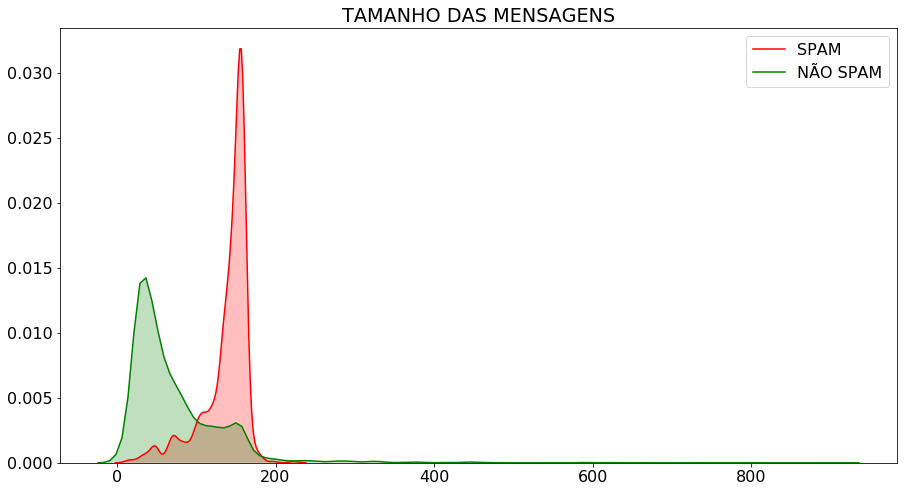

In [7]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,8))
sns.kdeplot(ms[ms['LABEL'] == 'spam']['TAMANHO_MS'], shade=True,label='SPAM', color='r').set_title('TAMANHO DAS MENSAGENS')
sns.kdeplot(ms[ms['LABEL'] == 'ham']['TAMANHO_MS'], shade=True, label='NÃO SPAM', color='g')

# Preparação de dados para mineração de texto

## Tratando as pontuações e stopwords

Vamos criar uma função que retire pontuações e stopwords.

Além disso, na mesma função, vamos normalizar as palavras: tratamento das flexões (sufixos/prefixos), plurais, etc.

Para pontuação a classe string do python possui um atributo chamado punctuation (basicamente é uma string de pontuações).

Para os stopwords, corpus NLTK possui uma lista completa de palavras vazias (do inglês e outros idiomas).

Na normalização vamos usar um método PorterStemmer da biblioteca stem.

In [8]:
# IMPORTANDO STRING (PARA PONTUAÇÕES)
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
# IMPORTANDO OS STOPWORDS
from nltk.corpus import stopwords
# 5 EXEMPLOS DE STOP WORDS DO INGLÊS
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

In [10]:
# IMPORTANDO A BIBLIOTECA PORTER STEMMER
# VAMOS USA-LA PARA NORMALIZAR (STEMMING) OS TERMOS
from nltk.stem import PorterStemmer 

In [11]:
# FUNÇÃO QUE APLICA AS TRANSFORMAÇÕES NO TEXTO
def transfTexto(msg):
    
    # PARA CADA CARACTERE DA MENSAGEM FILTRA PONTUAÇÕES (not in string.punctuation)
    semPont = [char for char in msg if char not in string.punctuation]

    # JUNTA OS CARACTERES NOVAMENTE
    semPont = ''.join(semPont)
    
    # REMOVE STOP WORDS
    remStWords = [palavra for palavra in semPont.split() if palavra.lower() 
                  not in stopwords.words('english')]
    
    # NORMALIZA POR STEMMING E RETORNA O RESULTADO
    st = PorterStemmer()
    return [st.stem(stPalavra) for stPalavra in remStWords]


In [12]:
# APLICANDO A FUNÇÃO DE TRANSFORMAÇÃO
ms['MENSAGEM'].apply(transfTexto).head()

0    [Go, jurong, point, crazi, avail, bugi, n, gre...
1                         [Ok, lar, joke, wif, u, oni]
2    [free, entri, 2, wkli, comp, win, FA, cup, fin...
3        [U, dun, say, earli, hor, U, c, alreadi, say]
4    [nah, dont, think, goe, usf, live, around, tho...
Name: MENSAGEM, dtype: object

## Vetorização do texto (Word Count)
#### Passo 1: vetorizar
A partir desse ponto, vamos peparar as mensagens para que fiquem apropriadas para tarefas de ML.

Vamos usar a biblioteca feature_extraction do sklearn.

Nessa biblioteca encontramos a classe CountVectorizer. Essa classe implementa a vetorização Word Count.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

Como quase tudo no sklearn segue o pipeline fit/transform, aqui não é diferente.

É preciso fitar um objeto a partir dos dados e na sequência usar esse objeto para transformar os dados que queremos.

Vamos criar um objeto CountVectorizer chamado msVet a partir das mensagens. Depois usaremos esse mesmo objeto para transformar as mensagens.

In [14]:
# FITANDO UM OBJETO VETORIZADOR DE WORDCOUNT
vetorizadorWC = CountVectorizer(analyzer=transfTexto).fit(ms['MENSAGEM'])

In [15]:
# VETORIZANDO AS MENSAGENS
msVetWC = vetorizadorWC.transform(ms['MENSAGEM'])

Agora a nossa matriz esparsa usando wordcount sobre as mensagens.

Ela se chama msVet, e tem 5K linhas por 11K colunas

msVet não é visível no jupyter pois é um objeto compactado. Mas acredite, ele está lá...

In [16]:
msVetWC.shape

(5572, 8309)

#### Passo 2: criando o DF para aplicação de ML
Nossa variável de desfecho (LABEL) não está no objeto vetorizado.

Precisamos unir as coisas agora, uma vez que o desfecho é a variável que vamos usar para a classificação (spam/não spam).

O bloco abaixo une a matriz esparsa (vetorizada) com o LABEL das mensagens.

In [17]:
# PRIMEIRO É PRECISO TRANSFORMAR EM DATAFRAME A MATRIZ ESPARSA (OBJETO COMPACTADO)
msVetWCPandas = pd.DataFrame(msVetWC.todense(), columns=vetorizadorWC.get_feature_names())

# CONCATENANDO... (msWC = MENSAGENS USANDO WORD COUNT)
msWC = pd.concat([ms['LABEL'], msVetWCPandas], axis=1)

msWC.head()

,LABEL,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,»10,Ü,é,ü,üll,–,“,“harri,…,…thank
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vetorização do texto para TF-IDF
#### Passo 1: vetorizar

Idem a vetorização que fizemos a partir do word count, agora vamos criar uma nova vetorização baseada em TF-IDF.

Sklearn possui uma biblioteca específica para TF-IDF, chamada TfidfTransformer.

A dinâmica aqui é a mesma que vimos em Word Count, a diferença é que para calcularmos TF-IDF utilizamos a matriz espasa de Word Cound como input.

Sim! É preciso vetorizar por Word Count para depois aplicar TF-IDF!...

O pipeline é semelhante:

- Fitamos um objeto CountVectorizer

- Criamos um novo objeto (matriz esparsa) transformando os dados com o objeto fitado.

- Convertemos a matriz esparsa (vetorizada) para um frame pandas, para que possamos seguir trabalhando...


In [18]:
from sklearn.feature_extraction.text import TfidfTransformer

# CRIANDO O OBJETO VETORIZADOR
vetorizadorTFIDF = TfidfTransformer().fit(msVetWC)

# VETORIZANDO...
msVetTFIDF = vetorizadorTFIDF.transform(msVetWC)

# FORMATO
msVetTFIDF.shape

(5572, 8309)

Pronto! Agora temos um falor de TF-IDF para cada termo para cada bow do corpus.

Seguimos em frente...

#### Passo 2: criando o DF para aplicação de ML
Nossa variável de desfecho (LABEL) não está no objeto vetorizado.

Precisamos unir as coisas agora, uma vez que o desfecho é a variável que vamos usar para a classificação (spam/não spam).

O bloco abaixo une a matriz esparsa (vetorizada) com o LABEL das mensagens.

In [19]:
# PRIMEIRO É PRECISO TRANSFORMAR EM DATAFRAME A MATRIZ ESPARSA (OBJETO COMPACTADO)
msVetTFIDFPandas = pd.DataFrame(msVetTFIDF.todense(), columns=vetorizadorWC.get_feature_names())

# CONCATENANDO... (msTFIDF = MENSAGENS USANDO TFIDF)
msTFIDF = pd.concat([ms['LABEL'], msVetTFIDFPandas], axis=1)

msTFIDF.head()

,LABEL,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,»10,Ü,é,ü,üll,–,“,“harri,…,…thank
0,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adicionalmente, podemos visualizar os resultados de TF-IDF de cada termo em relação a todo o corpus:

In [42]:
# DEFINIMOS COMO INDICE OS TERMOS (BUSCAMOS DO OBJETO TREINADO ANTERIORMENTE NO WC)
msTFIDF = pd.DataFrame(vetorizadorTFIDF.idf_, index=vetorizadorWC.get_feature_names(),columns=['TF-IDF'])
 
# TEMOS UM VALORE DE TF-IDF PARA CADA TEMRO DISTINTO DO CORPUS...
msTFIDF.sort_values(by=['TF-IDF'], ascending = False).head()

,TF-IDF
…thank,8.932542
hellohow,8.932542
hersh,8.932542
heron,8.932542
heroi,8.932542


### Pronto!!
Agora temos dois datasets prontos para iniciar os trabalhos de ML: um WC (msWC) e outro TF-IDF (msTFIDF).

Obviamente o dataset vetorizado construído por WC resultará em um modelo inferior em relação ao TF-IDF. Será mesmo?

Nesse contexto, nossa objetivo é criar um fitro de spams, vamos em frente?..

-----------------------------